<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-2c,-continued:-Application-(R)" data-toc-modified-id="Chapter-2c,-continued:-Application-(R)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter 2c, continued: Application (R)</a></span><ul class="toc-item"><li><span><a href="#6.-The-time-to-failure-earthquake-prediction-method" data-toc-modified-id="6.-The-time-to-failure-earthquake-prediction-method-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>6. The time-to-failure earthquake prediction method</a></span></li><li><span><a href="#7.-References" data-toc-modified-id="7.-References-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>7. References</a></span></li></ul></li></ul></div>

# Chapter 2c, continued: Application (R)

This notebook contains an application of non-linear regression to some geodata. We move to R for this application as R functions are more straightforward than in Python to deal with an empirical formula with both fixed and variable parameters.


## 6. The time-to-failure earthquake prediction method

We will now consider two techniques, grid search and the Gauss-Newton algorithm (related to gradient descent), to find the parameters of a non-linear regression model to predict the occurrence time and magnitude of an upcoming earthquake. We will use Root mean squared error (RMSE) as performance metric. To do so, we will use the time-to-failure earthquake prediction method and reproduce a result from Brehm & Braile (1998) (see Figure).

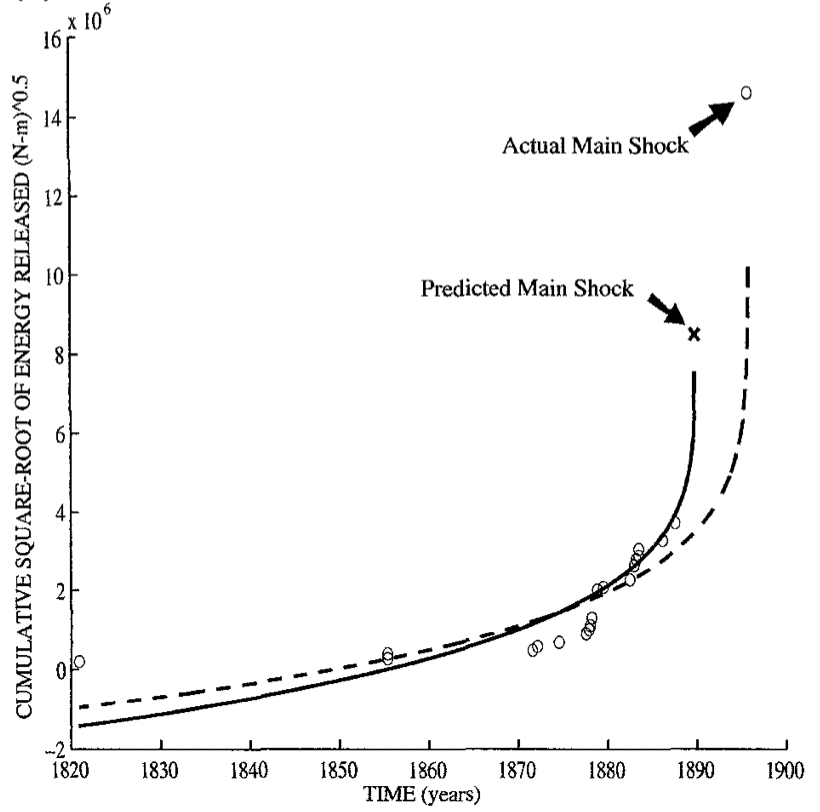

The simplest method ever devised to predict both the time of occurrence $t_f$ and magnitude $M$ of a large earthquake is the time-to-failure method described by Bufe & Varnes (1993), which led to the development of the subfield of precursory accelerating seismicity research (see review by Mignan et al., 2011). Originally justified on the basis of damage mechanics, the time-to-failure equation is a power-law of the form:

$$\epsilon (t) = \sum_{i=1}^{N(t)} E_i (t)^{1/2} = K - \frac{k}{m}(t_f-t)^m$$

which describes the temporal evolution of seismic precursors, where $\epsilon$ is the cumulative Benioff strain defined from the square root of the seismic energy $E$, $K$ is the total cumulative Benioff strain, $t_f$ is the time of the mainshock and $k$ and $m$ are constants. The method was later improved by Brehm & Braile (1998) by reducing the number of free parameters from four ($K$, $t_f$ , $k$ and $m$) to three ($K_m$, $t_f$ and $m$):

$$ \epsilon (t) = \sum_{i=1}^{N(t)} E_i (t)^{1/2} = (K_p + K_m) - f(K_m) (t_f-t)^m $$

where $K_p$, the total cumulative Benioff strain of precursors, is known, and $K_m$ is the Benioff strain released by the future mainshock which relates to its magnitude $M$ via the seismic energy $E = M_0/20000$, itself function of the seismic moment $M_0 = 10^{0.14M^2 + 0.36M + 10.76}$ (in N.m for the case of seismic-wave energy as a function of body wave magnitude). The function $f(K_m)$ constrains the ratio $k/m$ to the mainshock magnitude via the empirical relationship $\log_{10}(k/m) = 0.443 \log_{10} M_0 − 1.2429$.

We will reproduce the analysis done by Brehm & Braile (1998) for the 1895 M6.2 New Madrid earthquake based on the earthquake catalogue of Nuttli & Brill (1981) (`Nuttli_catalog.csv` preprocessed to obtain a similar time series as above).

In [411]:
seism <- read.csv('data/Nuttli_catalog.csv', header = T)
mainshock <- tail(seism, 1)# The last row of data
foreshocks <- seism[-nrow(seism), ]

foreshocks$cumBenioff <- cumsum(sqrt(foreshocks$E))
mainshock$cumBenioff <- max(foreshocks$cumBenioff) + sqrt(mainshock$E)
foreshocks

t,m,E,lon,lat,cumBenioff
1820.941,4.2,27578459563,89.5,37.3,166067.6
1855.425,3.8,7056185742,89.2,37.0,250068.7
1872.189,3.6,3709966639,89.2,37.0,310978.2
1874.608,3.6,3709966639,89.2,37.0,371887.7
1877.624,4.3,39406694255,89.7,36.8,570398.9
1877.969,3.6,3709966639,89.2,37.0,631308.4
1878.108,3.6,3709966639,89.2,37.0,692217.9
1878.283,4.2,27578459563,89.1,36.8,858285.6
1878.969,4.9,384034000000,89.3,36.7,1477990.3
1882.638,4.2,27578459563,89.2,36.9,1644058.0


In [412]:
mainshock

,t,m,E,lon,lat,cumBenioff
16,1895.918,6.2,1.18187e+14,89.4,37,13734954


**EXERCISE 4:** Plot the precursory time series and differentiate preshocks and mainshock using different colours and/or symbols. You should observe something similar to the figure from Brehm & Braile (1998) shown above. Use the same axis ranges using `xlim = c(xmin, xmax)` and `ylim = c(ymin, ymax)`.

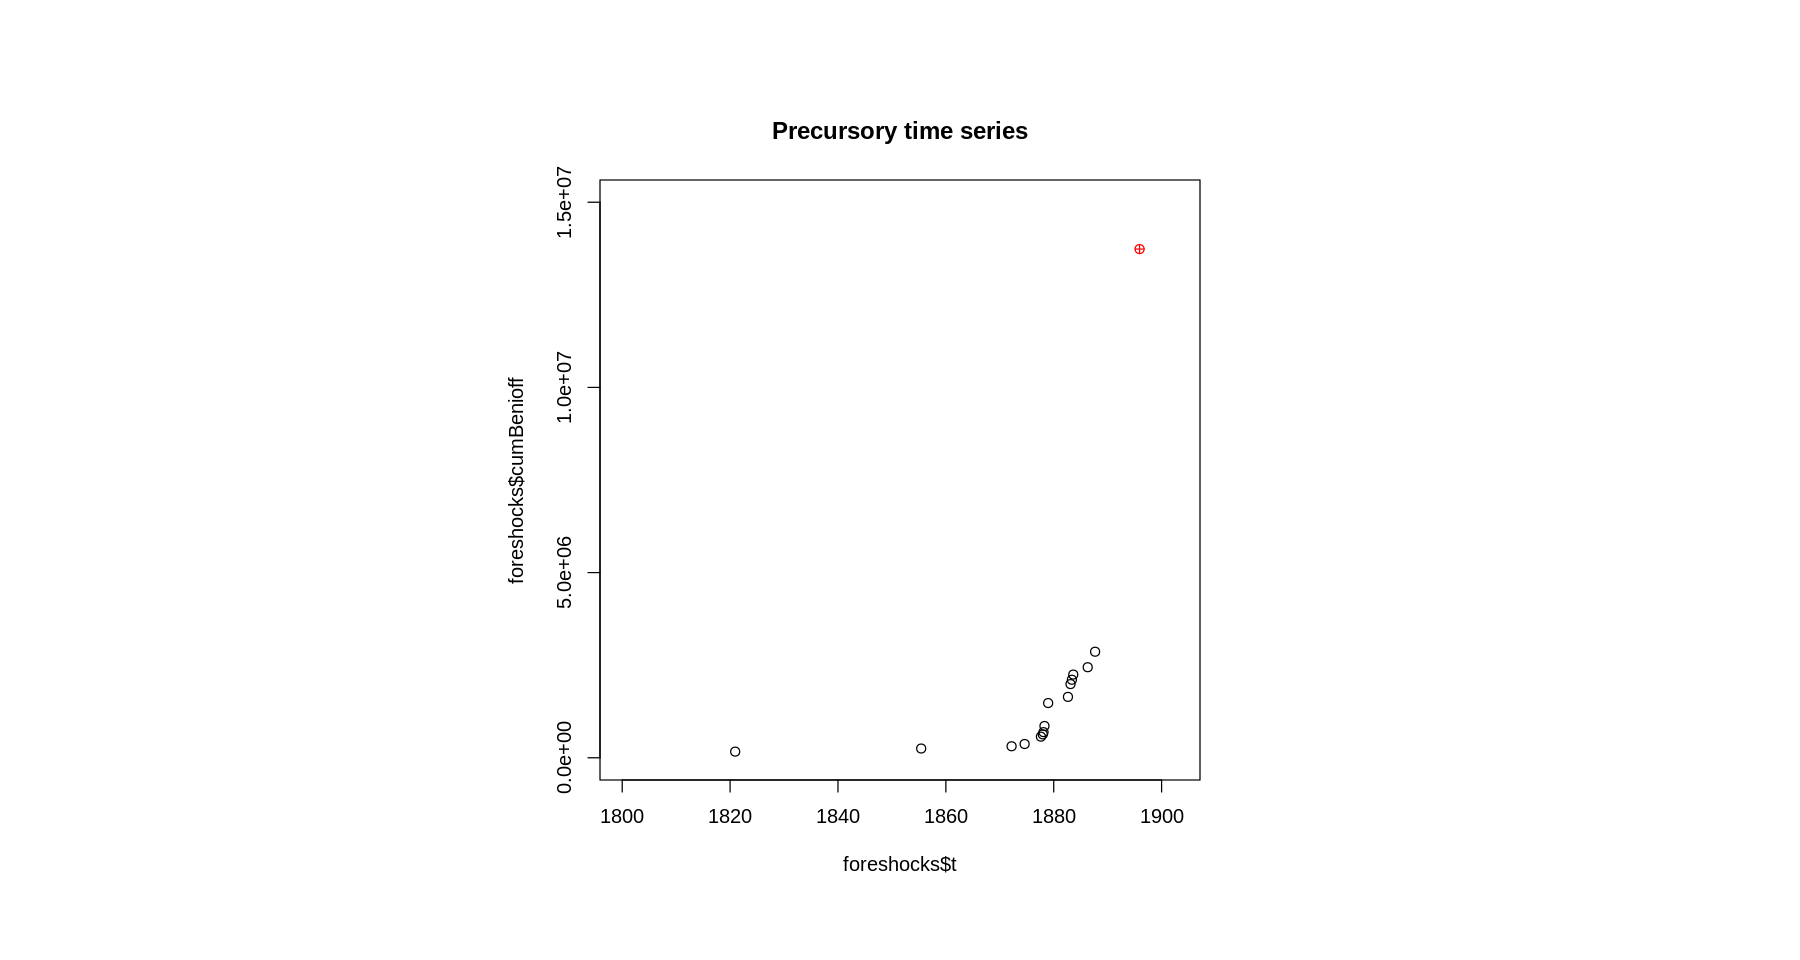

In [414]:
par(pin=c(5,5))
plot(foreshocks$t, foreshocks$cumBenioff,xlim=c(1800,1903), ylim=c(0,15000000),main='Precursory time series')
points(mainshock$t, mainshock$cumBenioff,col='red',pch=10)

We will now fit the Brehm & Braile (1998) equation to the preshock data. We need to estimate the 3 parameters $K_m$, $t_f$ and $m$. We are interested in $K_m$, proxy to the mainshock magnitude, and $t_f$, the mainshock occurrence time. We will therefore do a RMSE grid search for those two parameters, and for each ($K_m$, $t_f$) couple, directly estimate the power exponent $m$ using the `nls()` function default algorithm (Gauss-Newton algorithm - to be discussed in a future lecture).

**EXERCISE 5:** Estimate the RMSE in a grid search for different $t_f$ and $M$ values (ranges given below). The parameter $m$ will be estimated with the function `nls()` keeping all other parameters constant. In `nls(formula, data, ...)`, the formula takes the form `y ~ a*x+b` for a linear regression for instance. _Hint:_ The residual of the model is given in `resid(fit)`.

In [415]:
tf_i <- seq(1888, 1900, .05)
M_j <- seq(5, 6.5, .05)
n_tf <- length(tf_i)
n_M <- length(M_j)

#YOUR CODE HERE
Kp <- max(foreshocks$cumBenioff)

RMSE <- array(dim = c(n_tf,n_M))
m    <- array(dim = c(n_tf,n_M))
km_ratio <- array(dim = c(n_tf,n_M))

for(i in 1:n_tf){
    if(i%%50 == 0) print(paste(i, '/', n_tf))#contour line ticks
    
    for(j in 1:n_M){
        # define parameters
        M0 <- 10^(0.14*M_j[j]^2+0.36*M_j[j]+10.76)
        Km <- sqrt(M0/20000)
        km_ratio[i,j] <- 10^(0.443*log10(M0)-1.2429)
        
        # nonlinear least-square with Gauss-Newton algorithm to estimate m while keeping others constant
        fit <- nls(cumB~(Kp+Km)-km_ratio[i,j]*((tf_i[i]-t)^m),
                   data=data.frame(t=c(foreshocks$t,tf_i[i]),cumB=c(foreshocks$cumBenioff,(Kp+Km))),
                   start = list(m = .5))
        
        m[i,j] <- coef(fit)["m"]
        RMSE[i,j] <- sqrt(sum(resid(fit)^2)/length(resid(fit)))
    }
}

[1] "50 / 241"
[1] "100 / 241"
[1] "150 / 241"
[1] "200 / 241"


Let us now plot the results of the RMSE grid search. If there is no error in the previous cell, you should obtain a surface resembling roughly to the one of Brehm & Braile (1998):

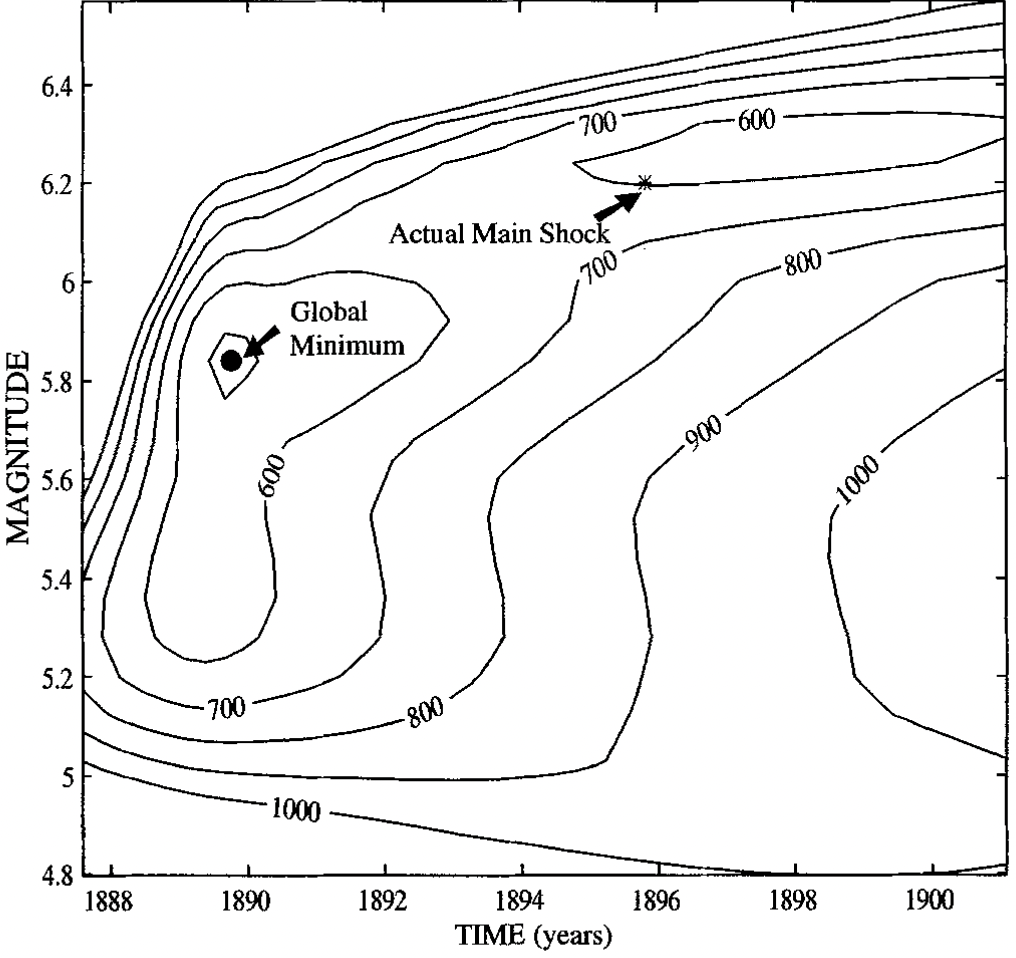

**EXERCISE 6:** First, find the mainshock time of occurrence and magnitude predicted by the model. What is the matching power exponent of the power time-ot-failure equation? To find the indices of an array based on a condition, use `which(CONDITION, arr.ind = T)`

In [418]:
mainshock

,t,m,E,lon,lat,cumBenioff
16,1895.918,6.2,1.18187e+14,89.4,37,13734954


In [443]:
tf_pred <- tf_i[which(RMSE==min(RMSE),arr.ind=T)[1]]
M_pred  <- M_j[which(RMSE==min(RMSE),arr.ind=T)[2]]

print(paste('Predicted mainshock (tf, M): (',tf_pred, ',', M_pred,')'))
print(paste('Observed mainshock (tf, M): (', mainshock$t, ',', mainshock$m, ')'))

power_exp = m[which(tf_i==tf_pred),which(M_j==M_pred,arr.ind=T)]
print(paste('Power exponent:', power_exp))


[1] "Predicted mainshock (tf, M): ( 1891.25 , 5.65 )"
[1] "Observed mainshock (tf, M): ( 1895.918207 , 6.2 )"
[1] "Power exponent: 0.231010578613277"


**EXERCISE 7:** Plot the RMSE grid search result alongside the time series already shown previously but now with the model fit on top. On the RMSE grid search plot, add the location of the optimal parameter set. Use some of the R functions learned in the previous R notebook. As the RMSE includes some very high values, the color scheme may not highlight much variations. You may consider plotting the log10 of the RMSE instead. You may also add contour lines using `contour(x, y, f(x,y), levels = seq(fmin, fmax, length.out = NUMBER_CONTOURS), add = T)` (optional). For the fitted curve on the second plot, use the function `lines()` (same arguments as in `points()`). 

In [549]:
km_r = km_ratio[which(tf_i==tf_pred),which(M_j==M_pred)]

Km =sqrt(10^(.14*M_pred^2+0.36*M_pred+10.76)/20000)
Km

[1] 3027332

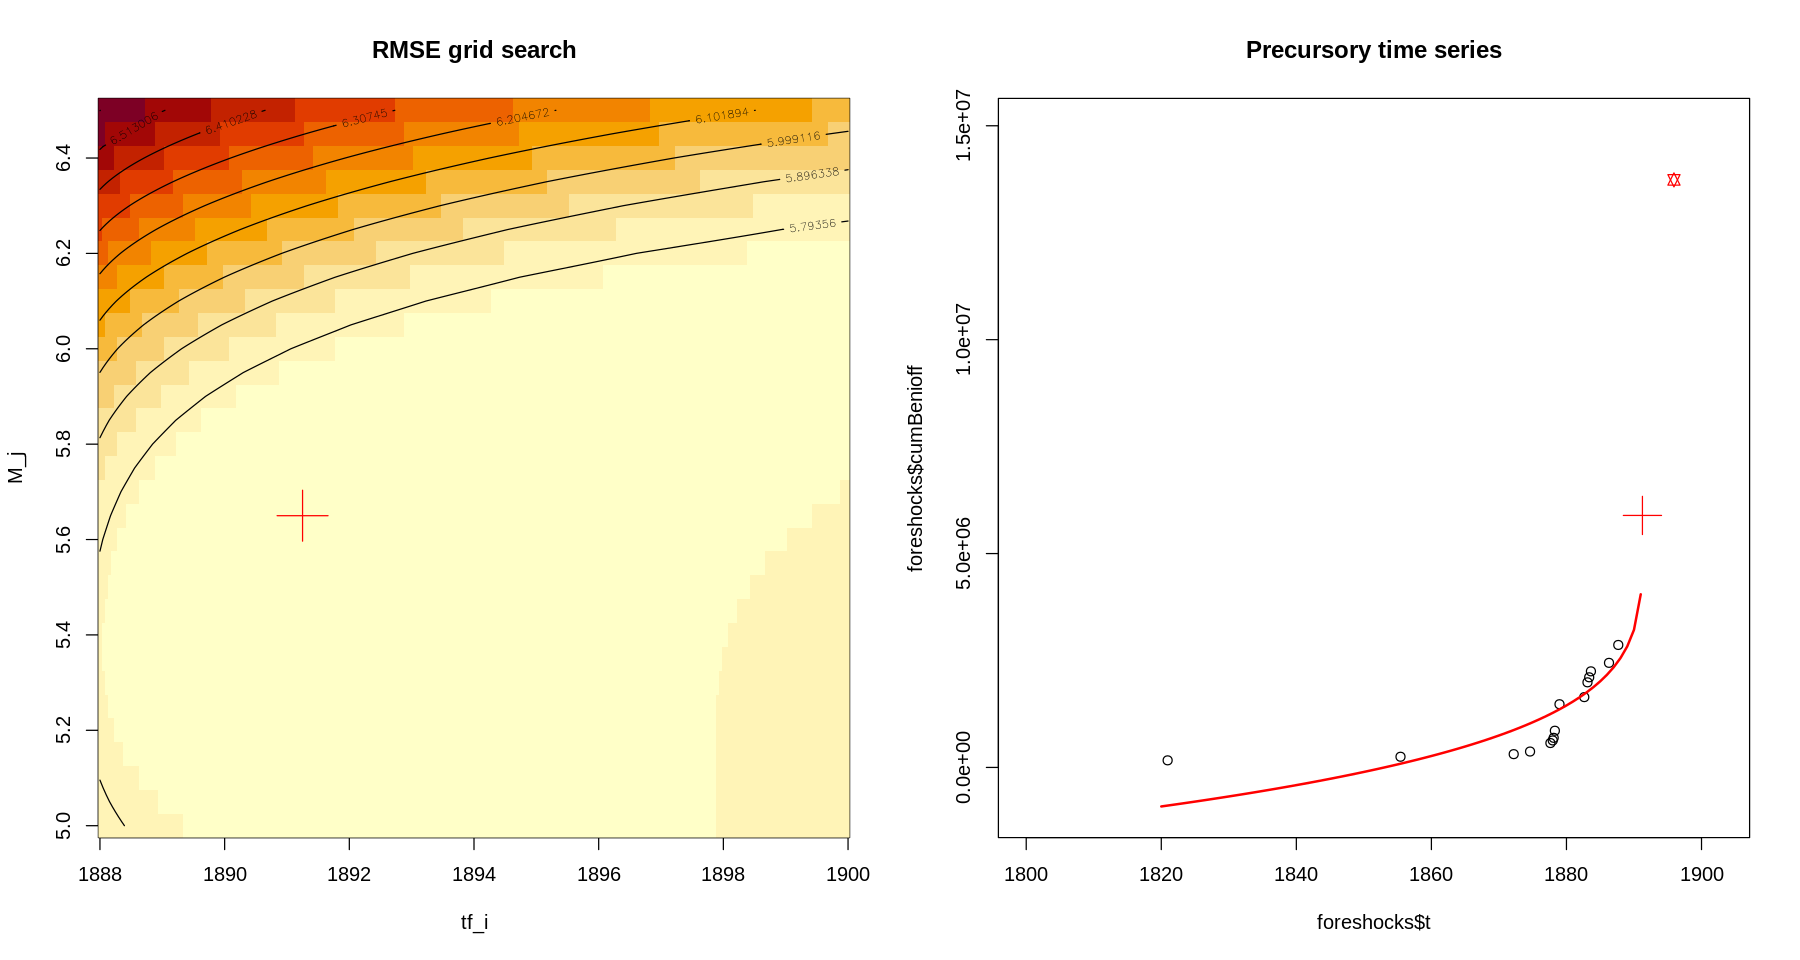

In [521]:
options(repr.plot.width = 15, repr.plot.height = 8)

par(mfrow = c(1, 2))

image(tf_i,M_j, matrix(log10(RMSE),nrow=n_tf,ncol=n_M),main="RMSE grid search")
contour(tf_i, M_j, matrix(log10(RMSE),nrow=n_tf,ncol=n_M),levels=seq(min(log10(RMSE)),max(log10(RMSE)),length.out=10),add=T)
points(tf_pred,M_pred,col='red',pch=3,cex=4)

plot(foreshocks$t, foreshocks$cumBenioff,xlim=c(1800,1903), ylim=c(-1000000,15000000),main='Precursory time series')
points(mainshock$t, mainshock$cumBenioff,col='red',pch=11,)
points(tf_pred, Kp+Km,col='red',pch=3,cex=3)

xx=seq(1820,round(tf_pred),1)
yy=Kp+Km-km_r*((tf_pred-xx)^power_exp)
lines(xx,yy,col='red',lw=2)

**EXERCISE 8:** Answer the following questions in words:
1. In view of the results, is the time-to-failure earthquake prediction method promising?
2. In view of what we learned in this lecture, is the published method (which we reproduced here) statistically correct? Detail your answer. _Hint: recall the assumptions behind the method of least squares_

In [524]:
mainshock

,t,m,E,lon,lat,cumBenioff
16,1895.918,6.2,1.18187e+14,89.4,37,13734954


In [581]:
km_r_obs=km_ratio[which(tf_i==1895.9),which(M_j==6.2)]
m_obs=m[which(tf_i==1895.9),which(M_j==6.2)]
x = seq(1820,1896,0.1)
y = 13734954-km_r_obs*(mainshock$t-x)^m_obs

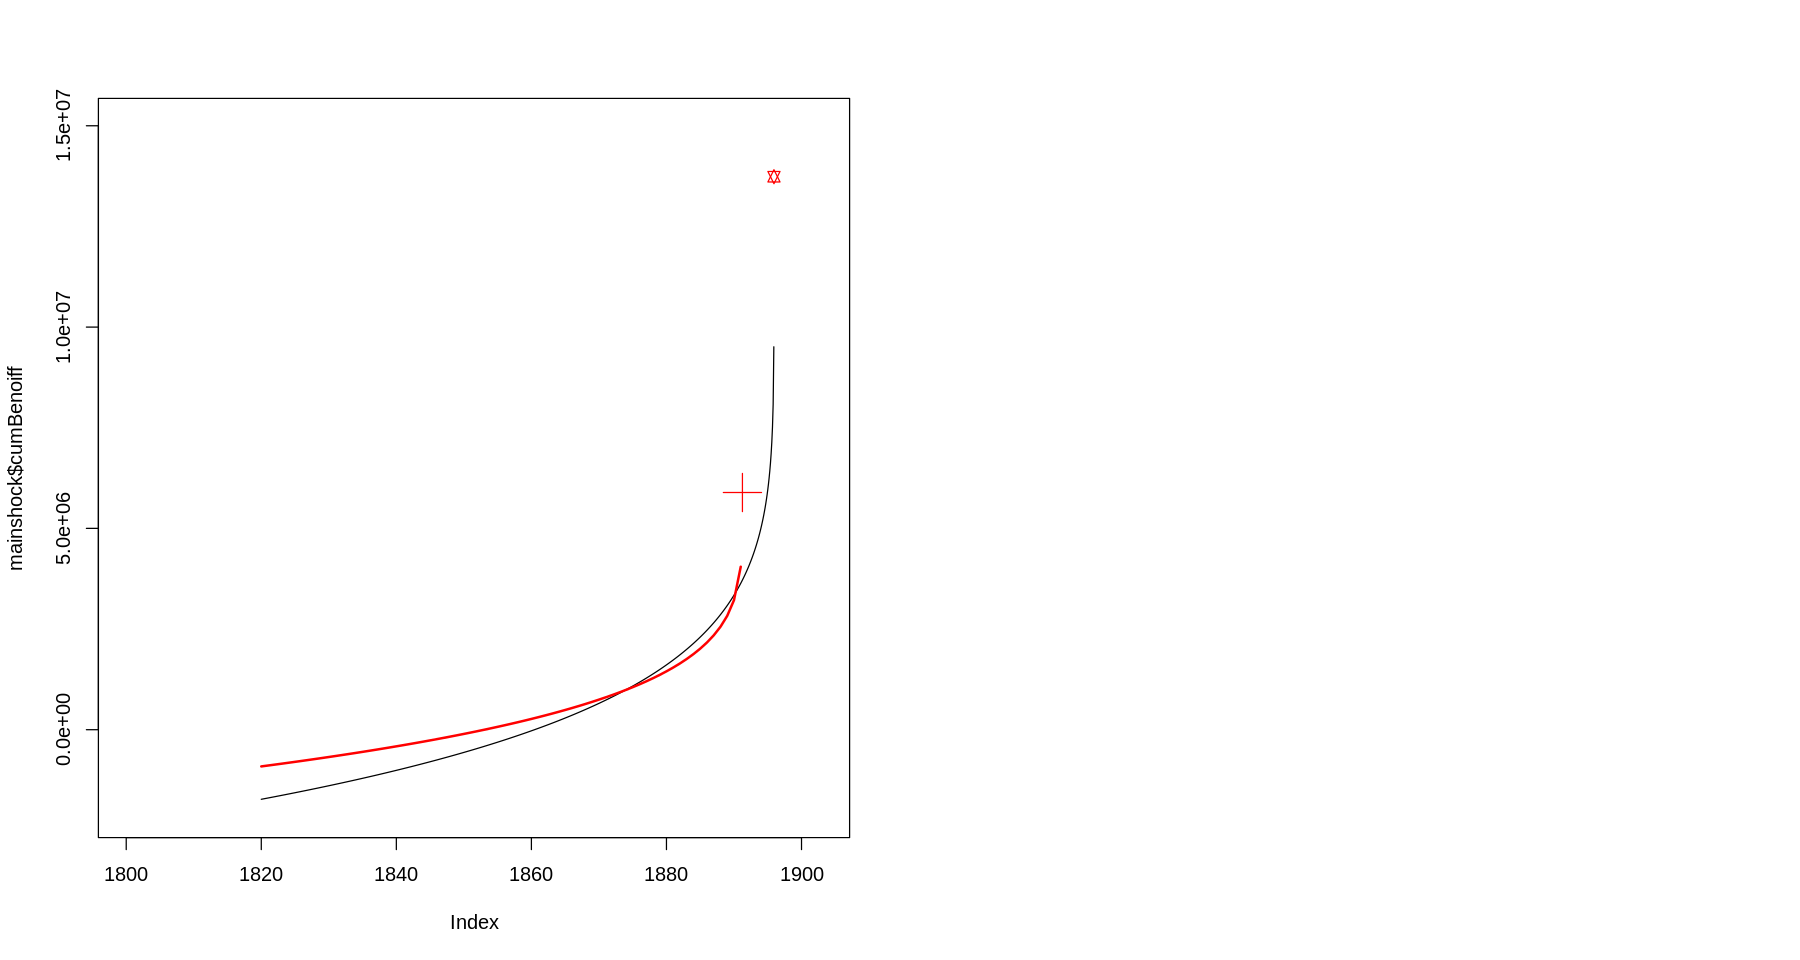

In [585]:
par(mfrow = c(1, 2))
plot(mainshock$t,mainshock$cumBenoiff,xlim=c(1800,1903), ylim=c(-2000000,15000000))
points(mainshock$t, mainshock$cumBenioff,col='red',pch=11,)
lines(x,y)

points(tf_pred, Kp+Km,col='red',pch=3,cex=3)
xx=seq(1820,round(tf_pred),1)
yy=Kp+Km-km_r*((tf_pred-xx)^power_exp)
lines(xx,yy,col='red',lw=2)

1. The time-to-failure prediction did not confirm a satisfying result because the predicted mainshock is ealier and cumulative Benoiff strain is much less compared to the observed mainshock.  
2. The published method is statistically correct, it generates the "best" fit of the preshocks and the mainshock. 

## 7. References

* Brehm & Braile (1998), Intermediate-Term Earthquake Prediction Using Precursory Events in the New Madrid Seismic Zone, Bull. Seismol. Soc. Am., 88 (2), 564-580
* Bufe & Varnes (1993), Predictive Modeling of the Seismic Cycle of the Greater San Francisco Bay Region, J. Geophys. Res., 98 (B6), 9871-9883
* Mignan (2011), Retrospective on the Accelerating Seismic Release (ASR) hypothesis: Controversy and new horizons, Tectonophysics, 505, 1-16